In [1]:
import pandas as pd
from Bio import SearchIO
from Bio import SeqIO
from Bio import Phylo
import os
import re
import glob
import regex

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

from multiprocessing import Pool
from functools import partial
import numpy as np

# from check_seq import check_seq
# from check_seq import conditional_check_seq

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
date = "20260114"

## Parse HMM output and grab hits; hits must meet the following criteria
- positive bit score
- full sequence evalue must be significant (<0.01)
- best domain evalue should be significant (<0.01)
    - otherwise flagged for manual review to check if it is distant homolog or just short repeats

### Store hits in feather file

In [ ]:
import pandas as pd
from Bio import SearchIO
import re
import glob
import sys

# get folder
dir = sys.argv[1]

# Get taxonomy from GTDB, https://data.ace.uq.edu.au/public/gtdb/data/releases/latest/
    # NCBI taxonomy from metadata files

GTDB_taxonomy = pd.read_csv('GTDB_taxonomy.gz', header = None, sep = '\t', names=['GenomeID', 'GTDB'])


'''Parse HMM output and grab hits; hits must meet the following criteria
- positive bit score
- full sequence evalue must be significant (<0.01)
- best domain evalue should be significant (<0.01)
    - otherwise flagged for manual review to check if it is distant homolog or just short repeats

Store hits in feather file'''

# Create empty lists
result_target = []
query_id = []
hit_id = []
evalue = []
best_domain_evalue = []
bitscore = []
bias = []
location = []
alength = []
slength = []
flag1 = []
flag2 = []

def append_hit(genomeID, gene, item):
    result_target.append(genomeID)
    query_id.append(gene)
    hit_id.append(item.id)
    evalue.append(item.evalue)
    best_domain_evalue.append(item.hsps[0].evalue)
    bitscore.append(item.bitscore)
    bias.append(item.bias)
    s = r'# ([0-9]+) # ([0-9]+)'
    location.append(re.match(s, item.description).group(1) + "-" + re.match(str, item.description).group(2))
    alength.append(item.hsps[0].aln_span)
    slength.append(int(re.match(s, item.description).group(2))-int(re.match(str, item.description).group(1)))

# Parse through files in output directory

for file in glob.glob(f'../results/{dir}/hmmsearch_results/*.out'):

    # RegEx for the GenomeID (double checking that file is really a genome)
    try:
        s = r'([\w]+_[\w]+_[\d]+\.[\d])'
        genomeID = re.search(s, file).group()
    except:
        continue

    # Parse file using SearchIO/HmmerIO
    for result in SearchIO.parse(file, 'hmmer3-text'):
        for item in result.hits:

            # grab gene name
            s = r'([a-zA-Z]+)' # ex. nifHDK, pchlide
            gene = re.findall(s, result.id)[0]

            # Check for positive bitscore and append the data to the corresponding lists
            if item.bitscore > 0 and item.evalue < 0.01:
                # append hits
                append_hit(genomeID, gene, item)

                # check if full seq and best domain e-val are significant
                if item.hsps[0].evalue < 0.01:
                    flag1.append(0)
                else:
                    # check if "full sequence Eval is sig but best domain is not, keep only if the target sequence "a multidomain remote homolog; but be wary, and watch out for the case where it’s just a repetitive sequence"
                    flag1.append(1)

                # check if bitscore >> bias (same order of magnitude) as bitscore
                if item.bias != 0 and item.bitscore/item.bias > 10:
                    flag2.append(0)
                else:
                    flag2.append(1)
                
# create and store dataframe
hits = pd.DataFrame({'GenomeID': result_target, 'Gene': query_id, 'Hit': hit_id, 
                     'E-value': evalue, 'Best Domain E-value': best_domain_evalue, 'Bit Score': bitscore, 'Bias': bias,
                     'Location': location, 'Alignment Length': alength, 'Sequence Length': slength, 
                     'Flag_Eval': flag1, 'Flag_Bias': flag2})

# add taxonomy info
hits = pd.merge(hits, GTDB_taxonomy, on = "GenomeID", how = "left")

# save as feather file
hits.to_feather(f'../results/{dir}/hits.feather')

## Parse hits to find best gene match
- Since nifDK are distantly related, they almost always both appear as hits for each other (how can I word this better)
- To properly assign the correct gene, select the hit with the highest bitscore/lowest evalue
- then consider operon organization
    - if more than 10 genes away (need a reference pt for this number, look for other hits)
- Keep genes from genomes that contain all nifHDK
- Store other less promising hits, for later validation

### Output top hits as feather file

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from itertools import combinations
from cluster_pos import cluster_pos

# get parsed hmm results
hits = pd.read_feather('archaea/hits.feather')

# save "contig" as col
hits['contig'] = hits['Hit'].str.split('_').str[:-1].str.join('_') 

# multi-index to cluster by genome, contig
hits.set_index(['GenomeID', 'contig'], inplace = True)
hits.sort_index(inplace = True)
hits.drop_duplicates(inplace = True)

# filter for genome, contig with at least 3 unique genes (nifHDKENB)
filtered_df = hits.groupby(level=['GenomeID', 'contig']).filter(lambda x: x['Gene'].nunique() >= 3)

# # make sure these 3 unique genes are not the same hit (i.e. not the same gene in reference genome)
filtered_df2 = filtered_df.groupby(level=['GenomeID', 'contig']).filter(lambda x: x['Hit'].nunique() >= 3)

genomes_to_keep = pd.DataFrame(columns = filtered_df2.columns)
genomes_to_keep['gene_cluster'] = 0

# iterate through each genome and contig
for genome in filtered_df2.index.get_level_values(0).unique(): # iterate through each genome
    for contig in filtered_df2.loc[genome].index.get_level_values(0).unique(): # iterate through each contig

        tmp = filtered_df2.loc[(genome, contig)]

        # only keep numbers that have clusters >= 3
        pos_clusters = cluster_pos(tmp.Hit.unique())

        # for each cluster
        for ind, cl in enumerate(pos_clusters):
            pos = [contig + '_' + str(p) for p in cl]
            no_pos = len(pos)
            
            # need at least 3 genes to continue
            if no_pos < 3:
                continue

            # only keep hits that are in the cluster
            tmp2 = tmp[tmp.Hit.isin(pos)]

            # only keep hits that are in the cluster
            tmp2 = tmp[tmp.Hit.isin(pos)].reset_index()

            tmp2['gene_cluster'] = ind + 1

            # save index
            genomes_to_keep = pd.concat([genomes_to_keep, tmp2])

# filter for genomes to keep
genomes_to_keep.to_feather('archaea/nif.feather')
genomes_to_keep.to_csv('archaea/nif.csv')


how many genomes only have nifDK?
How many genomes/contigs have multiple nifHDK motifs?
How many genes have both nifDK together --> i.e. no stop codon --> do they have two separate high scoring domains?

## Validate hits as correct nifHDK matches by checking for the presence of CDD's conserved features
- For nifD check for P-cluster and FeMoCo binding residues (https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd01976)
- For nifK check for P-cluster binding residues (https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd01974)
- For nifH check for active site, Fe-S cluster (https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=349759)

In [4]:
reload_fasta = False

In [3]:
# align hits

from Bio import AlignIO

# grab both archaea + bacteria hits
nif_archaea = pd.read_feather('results/archaea/nif.feather')
nif = nif_archaea.copy()
#nif_bacteria = pd.read_feather('results/bacteria/nif.feather')
#nif = pd.concat([nif_archaea, nif_bacteria])

nif.reset_index(inplace = True)
nif.set_index(['GenomeID'], inplace = True)
nif['Seq'] = ''

# separate by annotation
nifH = nif[nif.Gene == 'nifH']
nifD = nif[nif.Gene == 'nifD']
nifK = nif[nif.Gene == 'nifK']
nifB = nif[nif.Gene == 'nifB']
nifE = nif[nif.Gene == 'nifE']
nifN = nif[nif.Gene == 'nifN']

gene_list = [nifH, nifD, nifK, nifB, nifE, nifN]
gene_names = ['nifH', 'nifD', 'nifK', 'nifB', 'nifE', 'nifN']

if reload_fasta: # should skip if fasta sequences have already been extracted
    # get fasta sequences for each gene & export to fasta
    for gene, name in zip(gene_list, gene_names):
        print(name)
        records = []
        for genome,hit in gene.iterrows():
            hit = hit.Hit

            file = glob.glob(f"all_rep_proteins_aa/*/{genome}_protein.faa")[0]
            
            for result in SeqIO.parse(file, "fasta"):
                if result.id == hit:
                    # store seq
                    gene.loc[genome, 'Seq'] = str(result.seq)
                    # convert to seqrecord
                    record = SeqRecord(Seq(result.seq), id=genome, description=hit)
                    records.append(record)
                    # exit loop once sequence is found
                    break
            
        # Write the records to a FASTA file
        with open("results/" + name + f"_{date}.fasta", "w") as output_handle:
            SeqIO.write(records, output_handle, "fasta")`

# align fasta files
for gene in gene_names:
    print("aligning "+ gene, flush=True)
    num = eval(f"int({gene}.shape[0]/200)+1") # how many splits
    os.system(f"seqtk split -n {num} results/fasta_splits/{gene}_split results/{gene}_{date}.fasta") # split fasta file
    for i in range(num):
        print(i+1)
        os.system(f"seqtk subseq results/{gene}_{date}.fasta results/ref_seq.ids >> results/fasta_splits/{gene}_split.{str(i+1).zfill(5)}.fa") # add reference sequences
        os.system(f"mafft --auto --quiet --thread 4 results/fasta_splits/{gene}_split.{str(i+1).zfill(5)}.fa > results/fasta_splits/{gene}_split.{str(i+1).zfill(5)}.aln")

nifH
1
2
3
4
5
6
nifD
1
2
3
4
5
6
7
8
9
10
11
nifK
1
2
3
4
5
6
7
8
9
10
11
nifB
1
2
3
nifE
1
2
3
4
5
6
7
8
9
10
11
nifN
1
2
3
4
5
6
7
8
9
10
11
12


In [5]:
# nif_archaea = pd.read_feather('archaea/nif.feather')
# # nif = nif_archaea.copy()
# nif_bacteria = pd.read_feather('bacteria/nif.feather')
# nif = pd.concat([nif_archaea, nif_bacteria])

nif.reset_index(inplace = True)
nif.set_index(['GenomeID', 'Hit','Gene'], inplace = True)
nif['Seq'] = ''


In [11]:
# check for conserved residues
from Bio import AlignIO
def check_gene(gene, ref_seq, important_residues, passing_score, p=False):
    
    alignment = AlignIO.read(f"{gene}.aln", "fasta")

    for record in alignment:
        print(record.description)
        if ref_seq in record.description:
            print()
            aln = record.seq
            break
    
    # map important cols in aln to ref_seq
    residue_to_alignment = {}
    residue_idx = 0  # index in original (ungapped) sequence
    col2res = {}

    for aln_idx, char in enumerate(aln):
        if char != '-':
            residue_idx += 1
            if residue_idx in important_residues:
                residue_to_alignment[residue_idx] = aln_idx
                col2res[aln_idx] = aln[aln_idx]
                
            # early stop if we've found everything
            if len(residue_to_alignment) == len(important_residues):
                break

    # print the corresponding residues in the original sequence
    if p:
        for residue, aln_idx in residue_to_alignment.items():
            print(f"Residue {residue} corresponds to alignment index {aln_idx}: {aln[aln_idx]}", flush = True)

    # store in dataframe        
    acc = [result.id for result in alignment]
    seqs = [list(str(result.seq)) for result in alignment]
    hits = [result.description.split(' ')[-1] for result in alignment]

    pssm = pd.DataFrame(seqs, index = acc)

    pssm = pssm.iloc[:, list(residue_to_alignment.values())]
    pssm['hit'] = hits
    pssm['contig'] = pssm['hit'].str.split('_').str[:-1].str.join('_')
    
    # check if cols contain correct residue for function
    def check_res(row):
        score = 0
        for col in residue_to_alignment.values():
            if row[col] == aln[col]:
                score += 2
                if aln[col] == 'C': # higher weight for correct C
                    score += 1
            elif aln[col] == 'C': # if ref seq is C, must also be C
                continue
            elif row[col] != '-': # greater penalty for gap than incorrect residue
                score += 1
        if score >= passing_score:
            return score
        else:
            return np.nan
        #return score

    pssm['score'] = pssm.apply(check_res, axis = 1)
    pssm.dropna(subset = ['score'], inplace = True)
    # rename cols
    pssm.rename(columns = col2res, inplace = True)

    return pssm


In [ ]:
# nifH

important_residues_nifH = [8, 9, 10, 11, 13, 14, 15, 38, 40, 42, 95, 127, 130] # methanosarcina
#important_residues_nifH = [10, 11, 12, 13, 15, 16, 17, 40, 42, 44, 98, 130, 133] # azotobacter
#GKGGGKS DKD CDC --> also returns BchL, ChlL, and BchX

ref_seq = 'NC_003552.1_4100'
ref_seq_nifH = 'NZ_BSFG01000004.1_46'

passing_score = 25 # try 28 (complete match?)

# initialize dataframe
nifH_checked = check_gene('results/fasta_splits/nifH_split.00001', ref_seq_nifH, important_residues_nifH, passing_score, p=True)

for file in glob.glob(f'results/fasta_splits/nifH_split.000*.aln'):
    if file == 'results/fasta_splits/nifH_split.00001.aln':
        continue
    new = check_gene(file[:-4], ref_seq_nifH, important_residues_nifH, passing_score)
    nifH_checked = pd.concat([nifH_checked, new])

nifH_checked.drop_duplicates(subset = ['hit'], inplace = True)
nifH_checked.set_index(['hit'], append= True, inplace = True)

print(str(len(nifH_checked)) + " nifH seqs")

# potentially also YAANN 159-162, if 162 = R than def Bch
# might be easier to filter at nifEN step

GB_GCA_000306725.1 CP003083.1_1272
GB_GCA_000499765.1 HG425166.1_1663
GB_GCA_001509375.1 LGFT01000081.1_1
GB_GCA_001602645.1 LUYE01000021.1_25
GB_GCA_001723855.1 MCBC01000014.1_13
GB_GCA_002011165.2 MTMI02000009.1_227
GB_GCA_002067095.1 MVQD01000106.1_245
GB_GCA_002067705.1 MVRL01000088.1_88
GB_GCA_002068435.1 MVZQ01000082.1_8
GB_GCA_002495065.1 DADT01000005.1_34
GB_GCA_002495625.1 DAGC01000013.1_55
GB_GCA_002497075.1 DAML01000010.1_53
GB_GCA_002499455.1 DALN01000141.1_15
GB_GCA_002503135.1 DARA01000054.1_10
GB_GCA_002504405.1 DARO01000004.1_9
GB_GCA_002506015.1 DAWR01000075.1_9
GB_GCA_002507205.1 DAZF01000050.1_6
GB_GCA_002508465.1 DAQQ01000257.1_20
GB_GCA_002509495.1 DAEV01000020.1_8
GB_GCA_002839605.1 PGYK01000018.1_18
GB_GCA_002926195.1 MZXQ01000108.1_2
GB_GCA_003151535.1 PLXT01000078.1_8
GB_GCA_003158115.1 PMGM01000048.1_30
GB_GCA_003164755.1 PLUB01000010.1_109
GB_GCA_003194445.1 PQXF01000004.1_158
GB_GCA_003336485.1 QENH01000192.1_26
GB_GCA_003601795.1 PIXU01000248.1_4
GB_GCA_003

UnboundLocalError: cannot access local variable 'aln' where it is not associated with a value

In [ ]:
# nifD

# grab aln numbering to map to ref seq (azoto, methano)
#important_residues_nifD = [58, 84, 149, 186, 190, 267, 485] # methanosarcina
important_residues_nifD = [61, 62, 77, 83, 84, 85, 87, 88, 154, 195, 275, 349, 442] 
# GCDHGPGCCHCKH
# GC{A|S}DHGP{I|L|V}GCCHCKH
# CCCQHCH
# azotobacter --> removed Q/Gln at 191 b/c not group IV
# Group IVA do not have H at 442, instead have GDE (LLIGDE) motif (July 23)
    # but have H at 426
    # P-cluster, nifK has 2nd Cys --> S/A GPGC at ~36
# MarDK (GroupIVC) also do not have H at 442, also have GDE (PLGDE) motif but conserved region upstream which is different than Group IVA
    # but have H at 429 that ligates FeMoco
    # P-cluster, marK has 2nd Cys --> CGPGC at ~36
# if MarDk does not have homocitrate, does GroupIVA --> what residues help coordinate homocitrate?
# appears that some groups have H442R,K

#ref_seq = 'NC_003552.1_4103'
ref_seq_nifD = 'NZ_BSFG01000004.1_45' # azo

passing_score = 15

# initialize dataframe
nifD_checked = check_gene('fasta_splits/nifD_split.00001', ref_seq_nifD, important_residues_nifD, passing_score, p=True)

for file in glob.glob(f'fasta_splits/nifD_split.00*.aln'):
    if file == 'fasta_splits/nifD_split.00001.aln':
        continue
    new = check_gene(file[:-4], ref_seq_nifD, important_residues_nifD, passing_score)
    nifD_checked = pd.concat([nifD_checked, new])

# for each genome, only keep the best hit per gene cluster
nifD_checked.drop_duplicates(subset = ['hit'], inplace = True)
nifD_checked.set_index(['hit'], append= True, inplace = True)
nifD_checked['gene_cluster'] = nif.loc[(nifD_checked.index.get_level_values(0), nifD_checked.index.get_level_values(1), 'nifD'), 
                                       'gene_cluster'].values
nifD_checked = nifD_checked.loc[nifD_checked.groupby(['contig', 'gene_cluster'])['score'].idxmax()]
#nifD_checked.drop_duplicates(inplace = True) # --> was previously dropping hits across same contig even if not same gene

print(str(len(nifD_checked)) + " nifD seqs")

Residue 62 corresponds to alignment index 93: C
Residue 88 corresponds to alignment index 119: C
Residue 154 corresponds to alignment index 194: C
Residue 191 corresponds to alignment index 239: Q
Residue 195 corresponds to alignment index 243: H
Residue 275 corresponds to alignment index 356: C
Residue 442 corresponds to alignment index 566: H
14 nifD seqs


In [ ]:
# nifE check

important_residues_nifE = [25, 37, 62, 83, 84, 85, 124] # azo, known catalytic
#important_residues_nifE = [25, 37, 62, 124, 46, 51, 155, 163, 324, 395]
# important_residues = [25, 37, 62, 124] # azotobacter YF39, G31, G41, L46, D51, E90, G96, L102, P115, I129, D132, P147, G155, G163, G202, G221, P268, G276, G324, G347, D395, G427
# CCCHGPC

# ref_seq = 'NC_003552.1_4105' # methano
ref_seq_nifE = 'NZ_BSFG01000004.1_39' # azo

passing_score = 12

nifE_checked = check_gene('fasta_splits/nifE_split.00001', ref_seq_nifE, important_residues_nifE, passing_score, p=True)

for file in glob.glob(f'fasta_splits/nifE_split.000*.aln'):
    if file == 'fasta_splits/nifE_split.00001.aln':
        continue
    new = check_gene(file[:-4], ref_seq_nifE, important_residues_nifE, passing_score)
    nifE_checked = pd.concat([nifE_checked, new])

nifE_checked.drop_duplicates(subset = ['hit'], inplace = True)
nifE_checked.set_index(['hit'], append= True, inplace = True)

#remove nifD hits from nifE
nifE_checked = nifE_checked[~nifE_checked.index.get_level_values(1).isin(nifD_checked.index.get_level_values(1).to_list())]

#for each genome, only keep the best hit per gene cluster
nifE_checked['gene_cluster'] = nif.loc[(nifE_checked.index.get_level_values(0), nifE_checked.index.get_level_values(1), 'nifE'), 
                                       'gene_cluster'].values
nifE_checked = nifE_checked.loc[nifE_checked.groupby(['contig', 'gene_cluster'])['score'].idxmax()]

print(str(len(nifE_checked)) + " nifE seqs")

Residue 25 corresponds to alignment index 64: C
Residue 37 corresponds to alignment index 97: C
Residue 62 corresponds to alignment index 123: C
Residue 124 corresponds to alignment index 202: C
12 nifE seqs


In [ ]:
# nifK

# grab aln numbering to map to ref seq (azoto, methano)
#important_residues = [23, 48, 106, 141] # methanosarcina
important_residues_nifK = [70, 95, 153, 188] # azotobacter

#ref_seq = 'NC_003552.1_4104'
ref_seq_nifK = 'NZ_BSFG01000004.1_44'

passing_score = 9 # S188 has not been verified to be conserved

nifK_checked = check_gene('fasta_splits/nifK_split.00001', ref_seq_nifK, important_residues_nifK, passing_score, p=True)

for file in glob.glob(f'fasta_splits/nifK_split.000*.aln'):
    if file == 'fasta_splits/nifK_split.00001.aln':
        continue
    new = check_gene(file[:-4], ref_seq_nifK, important_residues_nifK, passing_score)
    nifK_checked = pd.concat([nifK_checked, new])

nifK_checked.drop_duplicates(subset = ['hit'], inplace = True)
nifK_checked.set_index(['hit'], append= True, inplace = True)

#remove nifD,E hits from nifK
nifK_checked = nifK_checked[~nifK_checked.index.get_level_values(1).isin(nifD_checked.index.get_level_values(1).to_list())]
nifK_checked = nifK_checked[~nifK_checked.index.get_level_values(1).isin(nifE_checked.index.get_level_values(1).to_list())]

#for each genome, only keep the best hit per gene cluster
nifK_checked['gene_cluster'] = nif.loc[(nifK_checked.index.get_level_values(0), nifK_checked.index.get_level_values(1), 'nifK'), 
                                       'gene_cluster'].values
nifK_checked = nifK_checked.loc[nifK_checked.groupby(['contig', 'gene_cluster'])['score'].idxmax()]

print(str(len(nifK_checked)) + " nifK seqs")

Residue 70 corresponds to alignment index 94: C
Residue 95 corresponds to alignment index 120: C
Residue 153 corresponds to alignment index 194: C
Residue 188 corresponds to alignment index 233: S
14 nifK seqs


In [ ]:
# nifN --> any other residues?? also check that not nifNB --> new criteria

# grab aln numbering to map to ref seq (azoto, methano)
#important_residues = [] # methanosarcina
important_residues_nifN = [44]#, 75] # azotobacter

#ref_seq = 'NC_003552.1_4106'
ref_seq_nifN = 'NZ_BSFG01000004.1_38'

passing_score = 3

nifN_checked = check_gene('fasta_splits/nifN_split.00001', ref_seq_nifN, important_residues_nifN, passing_score, p=True)
for file in glob.glob(f'fasta_splits/nifN_split.000*.aln'):
    if file == 'fasta_splits/nifN_split.00001.aln':
        continue
    new = check_gene(file[:-4], ref_seq_nifN, important_residues_nifN, passing_score)
    nifN_checked = pd.concat([nifN_checked, new])

nifN_checked.drop_duplicates(subset = ['hit'], inplace = True)
nifN_checked.set_index(['hit'], append= True, inplace = True)

# remove nifD,E,K hits from nifN
nifN_checked = nifN_checked[~nifN_checked.index.get_level_values(1).isin(nifD_checked.index.get_level_values(1).to_list())]
nifN_checked = nifN_checked[~nifN_checked.index.get_level_values(1).isin(nifE_checked.index.get_level_values(1).to_list())]
nifN_checked = nifN_checked[~nifN_checked.index.get_level_values(1).isin(nifK_checked.index.get_level_values(1).to_list())]

# for each genome, only keep the best hit per gene cluster
nifN_checked['gene_cluster'] = nif.loc[(nifN_checked.index.get_level_values(0), nifN_checked.index.get_level_values(1), 'nifN'), 
                                        'gene_cluster'].values
nifN_checked = nifN_checked.loc[nifN_checked.groupby(['contig', 'gene_cluster'])['score'].idxmax()]

print(str(len(nifN_checked)) + " nifN seqs")

## G at position (some have D, but BchB has gap)

Residue 44 corresponds to alignment index 1459: C
11272 nifN seqs


In [693]:
# nifB--> not done

# grab aln numbering to map to ref seq (azoto, methano)
important_residues = [] # methanosarcina
# important_residues = [] # azotobacter

ref_seq_nifB = 'NC_003552.1_4106'

passing_score = 0

nifB_checked = check_gene('nifB', ref_seq_nifB, important_residues, passing_score)

UnboundLocalError: cannot access local variable 'aln' where it is not associated with a value

In [ ]:
#get seq that failed checks

seqs = []

for gene in 'DKEN':

    # for each gene, get all hmm hit acc
    result = list(SeqIO.parse(f"nif{gene}.fasta", "fasta"))
    hit = [record.description.split(" ")[-1] for record in result]

    # get seq that failed check
    for record, acc in zip(result, hit):
        if acc not in eval(f"list(nif{gene}_checked.index.get_level_values(1).unique())"):
            seq = SeqRecord(Seq(record.seq), id=record.id, description=acc)
            seqs.append(record)


print(str(len(seqs)) + " seqs failed nifDKEN checks")

# Write the records to a FASTA file
with open(f"results/nifDKEN_{date}.fasta", "w") as output_handle:
    SeqIO.write(seqs, output_handle, "fasta")

# add reference sequences
for gene in 'DKEN':
    os.system(f"seqtk subseq results/nif{gene}.fasta results/ref_seq.ids >> results/nifDKEN_{date}.fasta")

print('aligning failed sequences', flush=True)

# aln all seqs
num = int(len(seqs)/200) +1  # how many splits
os.system(f"seqtk split -n {num} nifDKEN_split nifDKEN_{date}.fasta") # split fasta file
for i in range(num):
    print(i+1)
    os.system(f"seqtk subseq results/nifDKEN_{date}.fasta results/ref_seq.ids >> results/nifDKEN_split.{str(i+1).zfill(5)}.fa") # add reference sequences
    os.system(f"mafft --auto --quiet --thread 4 results/nifDKEN_split.{str(i+1).zfill(5)}.fa > results/nifDKEN_split.{str(i+1).zfill(5)}.aln")
   
# takes ~ 12 min (how much does this change now?)

131650 seqs failed nifDKEN check
aligning failed sequences


In [ ]:
nifD_backup = check_gene('fasta_splits/nifDKEN_split.00001', ref_seq_nifD, important_residues_nifD, 14)
nifK_backup = check_gene('fasta_splits/nifDKEN_split.00001', ref_seq_nifK, important_residues_nifK, 12)
nifE_backup = check_gene('fasta_splits/nifDKEN_split.00001', ref_seq_nifE, important_residues_nifE, 9)
nifN_backup = check_gene('fasta_splits/nifDKEN_split.00001', ref_seq_nifN, important_residues_nifN, 3)

for file in glob.glob(f'fasta_splits/nifDKEN_split.00*.aln'):
    if file == 'fasta_splits/nifDKEN_split.00001.aln':
        continue
    new = check_gene(file[:-4], ref_seq_nifD, important_residues_nifD, passing_score)
    nifD_backup = pd.concat([nifD_backup, new])

    new = check_gene(file[:-4], ref_seq_nifK, important_residues_nifK, passing_score)
    nifK_backup = pd.concat([nifK_backup, new])

    new = check_gene(file[:-4], ref_seq_nifE, important_residues_nifE, passing_score)
    nifE_backup = pd.concat([nifE_backup, new])

    new = check_gene(file[:-4], ref_seq_nifN, important_residues_nifN, passing_score)
    nifN_backup = pd.concat([nifN_backup, new])

# set index as genome, hit
nifD_backup.set_index(['hit'], append= True, inplace = True)

# remove hits that are already in saved
nifD_backup = nifD_backup[~nifD_backup.index.get_level_values(1).isin(nifD_checked.index.get_level_values(1).to_list())] # remove nifD
nifD_backup = nifD_backup[~nifD_backup.index.get_level_values(1).isin(nifK_checked.index.get_level_values(1).to_list())] # remove nifK
nifD_backup = nifD_backup[~nifD_backup.index.get_level_values(1).isin(nifE_checked.index.get_level_values(1).to_list())] # remove nifE
nifD_backup = nifD_backup[~nifD_backup.index.get_level_values(1).isin(nifN_checked.index.get_level_values(1).to_list())] # remove nifN

# for each genome, only keep the best hit per contig
nifD_backup['gene_cluster'] = 0
nifD_backup = nifD_backup.loc[nifD_backup.groupby(['contig'])['score'].idxmax()]
nifD_backup.drop_duplicates(inplace = True)

print(str(len(nifD_backup.index.unique())) + " nifD seqs", flush=True)
nifD_checked = pd.concat([nifD_checked, nifD_backup])

# set index as genome, hit
nifK_backup.set_index(['hit'], append= True, inplace = True)

# remove hits that are already in saved
nifK_backup = nifK_backup[~nifK_backup.index.get_level_values(1).isin(nifD_checked.index.get_level_values(1).to_list())] # remove nifD
nifK_backup = nifK_backup[~nifK_backup.index.get_level_values(1).isin(nifK_checked.index.get_level_values(1).to_list())] # remove nifK
nifK_backup = nifK_backup[~nifK_backup.index.get_level_values(1).isin(nifE_checked.index.get_level_values(1).to_list())] # remove nifE
nifK_backup = nifK_backup[~nifK_backup.index.get_level_values(1).isin(nifN_checked.index.get_level_values(1).to_list())] # remove nifN

# for each genome, only keep the best hit per contig
nifK_backup['gene_cluster'] = 0
nifK_backup = nifK_backup.loc[nifK_backup.groupby(['contig'])['score'].idxmax()]
nifK_backup.drop_duplicates(inplace = True)

print(str(len(nifK_backup.index.unique())) + " nifK seqs", flush=True)
nifK_checked = pd.concat([nifK_checked, nifK_backup])

# set index as genome, hit
nifE_backup.set_index(['hit'], append= True, inplace = True)

# remove hits that are already in saved
nifE_backup = nifE_backup[~nifE_backup.index.get_level_values(1).isin(nifD_checked.index.get_level_values(1).to_list())] # remove nifD
nifE_backup = nifE_backup[~nifE_backup.index.get_level_values(1).isin(nifK_checked.index.get_level_values(1).to_list())] # remove nifK
nifE_backup = nifE_backup[~nifE_backup.index.get_level_values(1).isin(nifE_checked.index.get_level_values(1).to_list())] # remove nifE
nifE_backup = nifE_backup[~nifE_backup.index.get_level_values(1).isin(nifN_checked.index.get_level_values(1).to_list())] # remove nifN

# for each genome, only keep the best hit per gene cluster
nifE_backup['gene_cluster'] = 0
nifE_backup = nifE_backup.loc[nifE_backup.groupby(['contig'])['score'].idxmax()]
nifE_backup.drop_duplicates(inplace = True)

print(str(len(nifE_backup.index.unique())) + " nifE seqs", flush=True)
nifE_checked = pd.concat([nifE_checked, nifE_backup])

# set index as genome, hit
nifN_backup.set_index(['hit'], append= True, inplace = True)

# remove hits that are already in saved
nifN_backup = nifN_backup[~nifN_backup.index.get_level_values(1).isin(nifD_checked.index.get_level_values(1).to_list())] # remove nifD
nifN_backup = nifN_backup[~nifN_backup.index.get_level_values(1).isin(nifK_checked.index.get_level_values(1).to_list())] # remove nifK
nifN_backup = nifN_backup[~nifN_backup.index.get_level_values(1).isin(nifE_checked.index.get_level_values(1).to_list())] # remove nifE
nifN_backup = nifN_backup[~nifN_backup.index.get_level_values(1).isin(nifN_checked.index.get_level_values(1).to_list())] # remove nifN

# for each genome, only keep the best hit per gene cluster
nifN_backup['gene_cluster'] = 0
nifN_backup = nifN_backup.loc[nifN_backup.groupby(['contig'])['score'].idxmax()]
nifN_backup.drop_duplicates(inplace = True)

print(str(len(nifN_backup.index.unique())) + " nifN seqs", flush=True)
nifN_checked = pd.concat([nifN_checked, nifN_backup])

#342,0,4680,2735
#428, 0,2870,2864


428 nifD seqs
0 nifK seqs
2870 nifE seqs
2864 nifN seqs


In [267]:
nif_archaea = pd.read_feather('archaea/nif.feather')
# nif = nif_archaea.copy()
nif_bacteria = pd.read_feather('bacteria/nif.feather')
nif = pd.concat([nif_archaea, nif_bacteria])

nif.reset_index(inplace = True)
nif.set_index(['GenomeID', 'Hit','Gene'], inplace = True)
nif['Seq'] = ''

In [ ]:
# append updated annotation (based on conserved residue matching) to nif files
nif['residue_match'] = ''
nif['backup_match'] = ''

nif.reset_index(level='Gene', inplace = True)
nif.sort_index(inplace = True)

# update residue match column in nif df
for gene in 'HDKEN':
    for genome, cols in eval(f"nif{gene}_checked.iterrows()"):
        nif.loc[(genome[0], genome[1]), 'residue_match'] = "nif" + gene
    
 # add backup check       
for gene in 'DKEN':
    for genome, cols in eval(f"nif{gene}_backup.iterrows()"):
        nif.loc[(genome[0], genome[1]), 'backup_match'] = "nif" + gene

# filter to get hits that passed residue matching
nifH = nif[(nif.residue_match == 'nifH') & (nif.Gene == 'nifH') & (nif['Alignment Length'] > 200)]
# nifB = nif[(nif.Gene == 'nifB')] # not done
# nifB['residue_match'] = 'nifB'

# only index OG matches
nifD = nif[((nif.residue_match == 'nifD') & (nif.Gene == 'nifD') & (nif.backup_match != 'nifD') & (nif['Alignment Length'] > 300))]
# add backup check
nifD_backup = nif[(nif.backup_match == 'nifD') & (nif['Alignment Length'] > 300)].sort_values(by = 'E-value')
nifD_backup = nifD_backup.groupby(['GenomeID', 'Hit']).first()
nifD = pd.concat([nifD, nifD_backup])

# only index OG matches
nifK = nif[((nif.residue_match == 'nifK') & (nif.Gene == 'nifK') & (nif.backup_match != 'nifK') & (nif['Alignment Length'] > 300))]
# add backup check
nifK_backup = nif[(nif.backup_match == 'nifK') & (nif['Alignment Length'] > 300)].sort_values(by = 'E-value')
nifK_backup = nifK_backup.groupby(['GenomeID', 'Hit']).first()
nifK = pd.concat([nifK, nifK_backup])

# only index OG matches
nifE = nif[((nif.residue_match == 'nifE') & (nif.Gene == 'nifE') & (nif.backup_match != 'nifE') & (nif['Alignment Length'] > 300))]
# add backup check
nifE_backup = nif[(nif.backup_match == 'nifE') & (nif['Alignment Length'] > 300)].sort_values(by = 'E-value')
nifE_backup = nifE_backup.groupby(['GenomeID', 'Hit']).first()
nifE = pd.concat([nifE, nifE_backup])

# only index OG matches
nifN = nif[((nif.residue_match == 'nifN') & (nif.Gene == 'nifN') & (nif.backup_match != 'nifN') & (nif['Alignment Length'] > 300))]
# add backup check
nifN_backup = nif[(nif.backup_match == 'nifN') & (nif['Alignment Length'] > 300)].sort_values(by = 'E-value')
nifN_backup = nifN_backup.groupby(['GenomeID', 'Hit']).first()
nifN = pd.concat([nifN, nifN_backup])

nif = pd.concat([nifH, nifD, nifK, nifE, nifN])
nif.sort_index(inplace = True)

nif.to_csv(f'nif_rescheck_nofilt_{date}.csv')


In [ ]:
# want to only keep contigs w/ nifHDKEN

from cluster_pos import cluster_pos

# make sure gene clusters have at least nifHDK
def gene_check(genes):
    if genes.__contains__('nifH'):
        if genes.__contains__('nifD'):
            if genes.__contains__('nifK'):
                return True

# multi-index to cluster by genome, contig
nif = pd.read_csv(f'nif_rescheck_nofilt_{date}.csv')
nif.reset_index(inplace = True)
nif.set_index(['GenomeID', 'contig'], inplace = True)
nif.sort_index(inplace = True)
nif.drop_duplicates(inplace = True)

# filter for genome, contig with at least 3 unique genes (nifHDKENB)
filtered_nif = nif.groupby(level=['GenomeID', 'contig']).filter(lambda x: x['Gene'].nunique() >= 3)

# make sure these 3 unique genes are not the same hit (i.e. not the same gene in reference genome)
filtered_nif2 = filtered_nif.groupby(level=['GenomeID', 'contig']).filter(lambda x: x['Hit'].nunique() >= 3)

genomes_to_keep = []
# iterate through each genome and contig
for genome in filtered_nif2.index.get_level_values(0).unique(): # iterate through each genome
    for contig in filtered_nif2.loc[genome].index.get_level_values(0).unique(): # iterate through each contig

        tmp = filtered_nif2.loc[(genome, contig)]

        # only keep numbers that have clusters >= 3
        pos_clusters = cluster_pos(tmp.Hit.unique(), 20)

        # for each cluster, find the best combination of genes (min e-value)
        for ind, cl in enumerate(pos_clusters):
            pos = [contig + '_' + str(p) for p in cl]
            no_pos = len(pos)
            
            # need at least 3 genes to continue
            if no_pos < 3:
                continue

            # only keep hits that are in the cluster
            tmp2 = tmp[tmp.Hit.isin(pos)]

            # only keep hits that are in the cluster
            tmp2 = tmp[tmp.Hit.isin(pos)].reset_index()

            # check if all genes are present
            if gene_check(tmp2.residue_match.to_list()):
                # get index
                items = [(genome, contig, hit) for hit in tmp2.Hit]
                genomes_to_keep.extend(items)

# filter for genomes to keep
filtered_nif2.set_index(['Hit'], append = True, inplace = True)
filtered_nif2 = filtered_nif2.loc[genomes_to_keep]
filtered_nif2.sort_index(inplace = True)

#clean up cols
filtered_nif2['Gene'] = filtered_nif2['residue_match']
filtered_nif2 = filtered_nif2[['Gene', 'E-value', 'Bit Score', 'Location', 'Orientation', 'Alignment Length', 'Sequence Length', 'GTDB']]
filtered_nif2.drop_duplicates(inplace = True)

# # export 
# filtered_nif2.to_feather(f'nif_final_{date}.feather')
# filtered_nif2.to_csv(f'nif_final_{date}.csv')

In [ ]:
filtered_nif2 = pd.read_feather(f'nif_final_{date}.feather')
filtered_nif2.loc[('GB_GCA_024402495.1')]

# GB_GCA_023439835.1 potential E for D
# GB_GCA_023228295.1 potential N for E, D for N
# RS_GCF_002934545.1 potential K fro E, E for K, D for N
# GB_GCA_016183425.1_JACPEP010000042.1_138 --> unknown
# GB_GCA_024698145.1 N for E, D for N --> both nifD in tree
# GB_GCA_031263985.1, GB_GCA_024402495.1 --> weird nifD
# GB_GCA_031273455.1_JAISRZ010000156.1_5 K for N
# GB_GCA_031273455.1_JAISRZ010000065.1_5 --> weird order but has nifHDKEN

Gene        E-value  Bit Score  \
contig            Hit                                                   
JAKSTR010000008.1 JAKSTR010000008.1_4  nifH  3.700000e-143      473.8   
                  JAKSTR010000008.1_6  nifD   1.100000e-61      205.9   
                  JAKSTR010000008.1_7  nifK   1.200000e-38      130.2   

                                        Location  Alignment Length  \
contig            Hit                                                
JAKSTR010000008.1 JAKSTR010000008.1_4  2680-3531               275   
                  JAKSTR010000008.1_6  3907-5382               437   
                  JAKSTR010000008.1_7  5384-6703               445   

                                       Sequence Length  \
contig            Hit                                    
JAKSTR010000008.1 JAKSTR010000008.1_4              851   
                  JAKSTR010000008.1_6             1475   
                  JAKSTR010000008.1_7             1319   

                                                                                    GTDB  
contig            Hit                                                                     
JAKSTR010000008.1 JAKSTR010000008.1_4  d__Bacteria;p__Spirochaetota;c__Spirochaetia;o...  
                  JAKSTR010000008.1_6  d__Bacteria;p__Spirochaetota;c__Spirochaetia;o...  
                  JAKSTR010000008.1_7  d__Bacteria;p__Spirochaetota;c__Spirochaetia;o...

In [270]:
nif.loc[('GB_GCA_005843815.1')]

,,index,E-value,Best Domain E-value,Bit Score,Bias,Location,Alignment Length,Sequence Length,Flag_Eval,Flag_Bias,GTDB,gene_cluster,contig,Seq
Hit,Gene,,,,,,,,,,,,,,
SZYA01000008.1_8,nifH,0,2.200000e-77,2.700000e-77,257.1,0.2,8036-8863,272,827,0,0,d__Bacteria;p__Bacteroidota;c__Chlorobiia;o__C...,1,SZYA01000008.1,
SZYA01000008.1_12,nifD,1,2.000000e-131,2.700000e-131,435.4,0.1,12198-13559,451,1361,0,0,d__Bacteria;p__Bacteroidota;c__Chlorobiia;o__C...,1,SZYA01000008.1,
SZYA01000008.1_13,nifD,2,9.500000e-17,1.200000e-15,57.2,0.0,13706-15025,388,1319,0,0,d__Bacteria;p__Bacteroidota;c__Chlorobiia;o__C...,1,SZYA01000008.1,
SZYA01000008.1_7,nifD,3,2.200000e-16,4.800000e-08,56.0,0.0,6401-7999,328,1598,0,0,d__Bacteria;p__Bacteroidota;c__Chlorobiia;o__C...,1,SZYA01000008.1,
SZYA01000008.1_11,nifD,4,5.600000e-14,1.200000e-12,48.1,0.0,10843-12201,260,1358,0,0,d__Bacteria;p__Bacteroidota;c__Chlorobiia;o__C...,1,SZYA01000008.1,
SZYA01000008.1_6,nifD,5,4.600000e-04,4.000000e+01,15.4,0.0,5102-6361,140,1259,1,0,d__Bacteria;p__Bacteroidota;c__Chlorobiia;o__C...,1,SZYA01000008.1,
SZYA01000008.1_13,nifK,6,1.000000e-188,1.200000e-188,624.6,0.0,13706-15025,443,1319,0,0,d__Bacteria;p__Bacteroidota;c__Chlorobiia;o__C...,1,SZYA01000008.1,
SZYA01000008.1_11,nifK,7,2.000000e-122,2.600000e-122,406.0,0.0,10843-12201,443,1358,0,0,d__Bacteria;p__Bacteroidota;c__Chlorobiia;o__C...,1,SZYA01000008.1,
SZYA01000008.1_12,nifK,8,4.500000e-28,4.800000e-22,94.8,0.1,12198-13559,331,1361,0,0,d__Bacteria;p__Bacteroidota;c__Chlorobiia;o__C...,1,SZYA01000008.1,


In [ ]:
filtered_nif2.loc[('GB_GCA_019561565.1')]
#nif[nif.GTDB.str.contains('Acidi')].head(40)#.index.get_level_values(0).unique().to_list()
# nif[(nif.backup_match!=nif.residue_match) & (nif.backup_match == 'nifK')]

# RS_GCF_027922225.1 Azotobacter vinelandii
# RS_GCF_001941975.1 Sporomusa sphaeroides (1 nif cluster, 1 unknown cluster--should not be returned in search results)
# RS_GCF_000214355.1 Leadbetter azotonutria ZAS-9
# RS_GCF_000214375.1 Treponema primitia ZAS-2
# RS_GCF_001027545.1 Endomicrobium proavitum
# RS_GCF_000297095.1 Treponema primitia ZAS-1 (3 gene clusters--1 is potentially not nitrogenase but unknown fxn)
# RS_GCF_000016665.1 Roseiflexus sp. RS-1 (1 nif cluster, 1 bch cluster--should not be returned in search results)
# RS_GCF_001045675.1 Megasphaera cerevisiae (1 nif cluster, 1 unknown fxn (ruminant guts)-- should not be returned in search results) --> looks like only has altnerative nif
# GB_GCA_016177775.1 Geobacter sp. likely only 1 true nif, 1 ambiguous (JACOUQ010000015.1)
# RS_GCF_008830225.1 multiple copies of nifH,N (NZ_WAIE01000001.1_498 likely false--~12 away from center)
# RS_GCF_009617575.1 Duplicate nifH needs to be dropped (NZ_WIXJ01000009.1_11)
# GB_GCA_004347685.1 Duplicate nifH (SLTJ01000030.1_8), very close to true genes...how to remove?
# RS_GCF_000025525.1 Methanocladococcus sp. strain FS406-22 (2nd K is E)
# GCF_000021865.1 Rhodobacter capsulatus -- missing! needs nif, anf, vnf
# RS_GCF_000007345.1 Methanosarcina acetivorans C2A, 1 nif, 1 anf, 1 vnf all on same contig
# RS_GCF_000017625.1 Methanoregula boonei
# GB_GCA_005843815.1 Chlorobium sp005843815 -- appears to have Bch + nif adjacent but only has one nifH/bchL SZYA01000008.1_8' -- COOL
# RS_GCF_000092305.1 Methanocaldococcus infernus -- true nif gene cluster (hyperthermophilic methanogen)
# RS_GCF_017912535.1 all out of order
# RS_GCF_000179635.2 Ruminococcus albus 7 nifHDK (NC_014833.1_2465)

Gene        E-value  Bit Score  \
contig            Hit                                                    
JAHEPY010000058.1 JAHEPY010000058.1_10  nifD  1.500000e-120      398.5   
                  JAHEPY010000058.1_12  nifK  1.700000e-167      553.6   
                  JAHEPY010000058.1_13  nifD  6.800000e-179      591.0   
                  JAHEPY010000058.1_16  nifH  1.800000e-137      453.6   
                  JAHEPY010000058.1_9   nifN  1.200000e-119      396.4   

                                           Location  Alignment Length  \
contig            Hit                                                   
JAHEPY010000058.1 JAHEPY010000058.1_10    8612-9955               453   
                  JAHEPY010000058.1_12  10549-11955               455   
                  JAHEPY010000058.1_13  11948-13384               472   
                  JAHEPY010000058.1_16  14379-15233               275   
                  JAHEPY010000058.1_9     7096-8415               437   

                                        Sequence Length  \
contig            Hit                                     
JAHEPY010000058.1 JAHEPY010000058.1_10             1343   
                  JAHEPY010000058.1_12             1406   
                  JAHEPY010000058.1_13             1436   
                  JAHEPY010000058.1_16              854   
                  JAHEPY010000058.1_9              1319   

                                                                                     GTDB  
contig            Hit                                                                      
JAHEPY010000058.1 JAHEPY010000058.1_10  d__Archaea;p__Methanobacteriota_A;c__Methanoco...  
                  JAHEPY010000058.1_12  d__Archaea;p__Methanobacteriota_A;c__Methanoco...  
                  JAHEPY010000058.1_13  d__Archaea;p__Methanobacteriota_A;c__Methanoco...  
                  JAHEPY010000058.1_16  d__Archaea;p__Methanobacteriota_A;c__Methanoco...  
                  JAHEPY010000058.1_9   d__Archaea;p__Methanobacteriota_A;c__Methanoco...

In [ ]:
# final fasta export
nif = pd.read_feather(f'nif_final_{date}.feather')

# export fasta files
nifH = nif[(nif.Gene == 'nifH')]
nifD = nif[(nif.Gene == 'nifD')]
nifK = nif[(nif.Gene == 'nifK')]
nifB = nif[(nif.Gene == 'nifB')]
nifE = nif[(nif.Gene == 'nifE')]
nifN = nif[(nif.Gene == 'nifN')]

gene_list = [nifH, nifD, nifK, nifB, nifE, nifN]
gene_names = ['nifH', 'nifD', 'nifK', 'nifB', 'nifE', 'nifN']

# get fasta sequences for each gene & export to fasta
for gene, name in zip(gene_list, gene_names):
    print(name)
    records = []

    for genome,hit in gene.iterrows():

        file = glob.glob(f"*/{genome[0]}_protein.faa")[0]

        for result in SeqIO.parse(file, "fasta"):
            if result.id == genome[2]:
                # store seq
                gene.loc[genome, 'Seq'] = str(result.seq)
                # convert to seqrecord
                record = SeqRecord(Seq(result.seq), id=genome[0], description=genome[2])
                records.append(record)
                # exit loop once sequence is found
                break
        
    # Write the records to a FASTA file
    with open("check_" + name + ".fasta", "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")


In [ ]:
# export in genomic-centric organization
nif = pd.read_feather(f'nif_final_{date}.feather')
nif.reset_index(inplace = True)

# load GTDB metadata
GTDB_metadata = pd.read_csv('GTDB_metadata.gz', sep = '\t', usecols=['accession', 'gtdb_taxonomy', 'ncbi_taxonomy', 
                                                'ncbi_taxonomy_unfiltered', 'ncbi_country', 'ncbi_isolation_source'])

# def for sorting gene order
def sort_order(g):
    order = ['H', 'D', 'K', 'B', 'E', 'N']
    return order.index(g)

# get gene set (i.e. HDKEN)
nif['Gene'] = nif['Gene'].str.replace('nif', '')
nif['Gene set'] = nif[['GenomeID','contig','Gene']].groupby(['GenomeID','contig'])['Gene'].transform(lambda x: ''.join(sorted(x, key=sort_order)))
# get contig positions (i.e. 1,2,3)
nif['index'] = nif['Hit'].str.split('_').str[-1]
nif['Position'] = nif[['GenomeID','contig','index']].groupby(['GenomeID','contig'])['index'].transform(lambda x: ','.join(sorted(x)))

# group by genome, contig and save
nif = nif[['GenomeID', 'contig', 'Gene set', 'Position', 'GTDB']]
nif = nif.groupby(['GenomeID','contig']).first()
nif.reset_index(level=['GenomeID','contig'], inplace = True)

#merge dataframes to include accession, metadata, and sequences (for filtering)
nif = pd.merge(nif, GTDB_metadata, left_on = 'GenomeID', right_on = 'accession', how = 'left').drop(columns = ['accession', 'gtdb_taxonomy'])

nif['An/aerobic'] = ''
nif['Thermophile'] = ''
nif['Culture'] = ''
nif['Reference'] = ''
nif.sort_index(inplace = True)
nif.set_index(['GenomeID', 'contig'], inplace = True)

#nif.to_csv(f'nif_genomes_{date}.csv') #--> do not overwrite! contains hand typped info!!!

### Assessing operon organization (what neighbors nifHDKEN clusters)

In [ ]:
# operon organization

from cluster_pos import cluster_pos

# grab checked nifHDKENB
nif = pd.read_feather(f'nif_final_{date}.feather')

#multi-index to cluster by genome, contig
nif.reset_index(inplace = True)
nif.set_index(['GenomeID', 'contig'], inplace = True)
nif.sort_index(inplace = True)
nif.drop_duplicates(inplace = True)

# iterate through each genome and contig
for genome in nif.index.get_level_values(0).unique(): # iterate through each genome
    for contig in nif.loc[genome].index.get_level_values(0).unique(): # iterate through each contig

        tmp = nif.loc[(genome, contig)]

        # get clusters
        pos_clusters = cluster_pos(tmp.Hit.unique(), 40)
        
        # get positions within +/-12 genes of center 
        for cl in pos_clusters:
            middle = cl[len(cl)//2] # center of cluster
            pos = [middle+num for num in range(-12,13) if middle+num > 0]
            acc = [contig + '_' + str(p) for p in pos] # get acc

            # write list items into a .txt file
            os.system("rm seqs.txt")
            with open("seqs.txt", "w") as f:
                for item in acc:
                    f.write(f"{item}\n")

            # save subsets as fasta
            try:
                file = glob.glob(f"*/{genome}_protein.faa")[0]
                os.system(f"seqtk subseq {file} seqs.txt > operon_org/{genome}_{contig}_operon.fasta")
            except:
                continue

In [ ]:
# plot operon-org of annotated genes
import requests

gene_abv = {'K00532': 'hydA', 'K07486':'tns', 'K07485':'tns', 'K07487':'tns', 'K13819': 'nifU'} # store ko2gene
gene_data = pd.DataFrame(columns = ['genome', 'contig', 'query_id', 'gene', 'ko_number', 'start', 'end', 'orientation'])

def ko2gene(ko):
    try:
        return gene_abv[ko]
    except:
        url = f"https://rest.kegg.jp/get/ko:{ko}"
        r = requests.get(url)
        for line in r.text.split("\n"):
            if line.startswith("SYMBOL"):
                gene = line.split()[-1]
                gene_abv[ko] = gene
                return gene

# grab annotation files
for file in glob.glob(f"../operon-org/microbeannotator/annotation_results/*"):
    # convet ko_number to gene abv
    annot = pd.read_csv(file, sep = '\t')
    annot['gene'] = annot['ko_number'].apply(ko2gene)
    
    # grab genome and contig from file name
    s = r'([A-Z_]+[A-Z0-9.]+)_([A-Z_]*[A-Z0-9.]+)'
    genome = re.search(s, file).group(1)
    annot['genome'] = genome
    contig = re.search(s, file).group(2)
    annot['contig'] = contig

    # grab start, end, orientation of each gene
    input = glob.glob(f"../operon-org/input-fastas/{genome}_{contig}_operon.fasta")[0]
    for result in SeqIO.parse(input, "fasta"):
        start = int(result.description.split('# ')[1])
        end = int(result.description.split('# ')[2])
        orientation = int(result.description.split('# ')[3])
        try:
            annot.loc[annot['query_id'] == result.id, 'start'] = start
            annot.loc[annot['query_id'] == result.id, 'end'] = end
            annot.loc[annot['query_id'] == result.id, 'orientation'] = orientation
        except:
            continue
    
    gene_data = pd.concat([gene_data, annot[['genome', 'contig', 'query_id', 'gene', 'ko_number', 'start', 'end', 'orientation']]])
    gene_data.to_csv('operon-org-plot-data.csv')



In [ ]:
# cool genomes

to_plot = [('RS_GCF_027922225.1', 'NZ_BSFG01000004.1'),
           ('RS_GCF_000214355.1', 'NC_015577.1'),
           ('RS_GCF_000025525.1', 'NC_013887.1'),
           ('RS_GCF_000017625.1', 'NC_009712.1'),
           ('RS_GCF_000007345.1', 'NC_003552.1'), # https://www.pnas.org/doi/10.1073/pnas.0602278103
           ('RS_GCF_000327045.1', 'NC_019940.1'),
           ('RS_GCF_001742305.1', 'NZ_MJAT01000037.1'),
           ('GB_GCA_031275645.1', 'JAISOL010000070.1'),
           ('GB_GCA_001184205.1', 'LBMP01000004.1'),
           ('RS_GCF_000016665.1', 'NC_009523.1'),
           ('RS_GCF_000146505.1', 'NC_017448.1')] 

thermo = ['RS_GCF_001687335.1',
 'RS_GCF_002898515.1',
 'RS_GCF_002093115.1',
 'RS_GCF_011207455.1',
 'RS_GCF_027925145.1',
 'GB_GCA_903896745.1',
 'RS_GCF_000195755.1',
 'RS_GCF_000266945.1',
 'GB_GCA_030065275.1',
 'RS_GCF_009688965.1',
 #'GB_GCA_947259715.1',
# 'RS_GCF_000711225.1',
 'GB_GCA_002423105.1',
 'GB_GCA_025355965.1',
 #'GB_GCA_030154185.1',
 'GB_GCA_015231595.1',
 'GB_GCA_003232385.1',
 'GB_GCA_023512345.1',
 'RS_GCF_030913705.1',
 'GB_GCA_003249225.1',
 'GB_GCA_003245715.1']


# RS_GCF_027922225.1 Azotobacter vinelandii
    # NZ_BSFG01000061.1 anf
    # NZ_BSFG01000004.1 nif
    # NZ_BSFG01000002.1 vnf
# RS_GCF_000179635.2 Ruminococcus albus 7
# RS_GCF_000013085.1 Rhodospirillum rubrum --> needs nif, anf --> also has MarDK
# RS_GCF_001941975.1 Sporomusa sphaeroides (1 nif cluster, 1 unknown cluster--should not be returned in search results)
# RS_GCF_000214355.1 Leadbetter azotonutria ZAS-9
# RS_GCF_000214375.1 Treponema primitia ZAS-2
# RS_GCF_001027545.1 Endomicrobium proavitum
# RS_GCF_000297095.1 Treponema primitia ZAS-1 (3 gene clusters--1 is potentially not nitrogenase but unknown fxn)
# RS_GCF_000016665.1 Roseiflexus sp. RS-1 (1 nif cluster, 1 bch cluster--should not be returned in search results)
# RS_GCF_001045675.1 Megasphaera cerevisiae (1 nif cluster, 1 unknown fxn (ruminant guts)-- should not be returned in search results)
# GB_GCA_016177775.1 Geobacter sp. likely only 1 true nif, 1 ambiguous (JACOUQ010000015.1)
# RS_GCF_008830225.1 multiple copies of nifH,N (NZ_WAIE01000001.1_498 likely false--~12 away from center)
# RS_GCF_009617575.1 Duplicate nifH needs to be dropped (NZ_WIXJ01000009.1_11)
# GB_GCA_004347685.1 Duplicate nifH (SLTJ01000030.1_8), very close to true genes...how to remove?
# RS_GCF_000025525.1 Methanocladococcus sp. strain FS406-22
# GCF_000021865.1 Rhodobacter capsulatus -- missing! needs nif, anf, vnf
# RS_GCF_000007345.1 Methanosarcina acetivorans C2A, 1 nif, 1 anf, 1 vnf all on same contig
# RS_GCF_000017625.1 Methanoregula boonei
# GB_GCA_005843815.1 Chlorobium sp005843815 -- appears to have Bch + nif adjacent but only has one nifH/bchL SZYA01000008.1_8' -- COOL


In [7]:
gene_data.loc[('RS_GCF_000016665.1')]
#gene_data[gene_data.gene == 'K07138'].index #016278505.1, 030653335.1, GB_GCA_031270875.1, ; 023443455.1; GB_GCA_900079695.1, 
#'Methanolinea_A sp018262855|sediment|GB_GCA_018262855.1|JADFDO010000016.1_17'
#'Methanoregula sp028679185|freshwater_wetland_soil|GB_GCA_028679185.1|JAJRBZ010000082.1_21'
#'W589 sp011171075|estuarine_anaerobic_sediment|GB_GCA_011171075.1|DUFD01000045.1_67'
#'Marinilabilia sp016278715|brine_fluids|RS_GCF_016278715.1|NZ_JADQBH010000117.1_7'

#'Rhodopseudomonas palustris_C|water|GB_GCA_000504425.1|KI632513.1_1533'
#'Methanoregula sp030653335|groundwater|GB_GCA_030653335.1|JAURZP010000061.1_17'

#NFS1 = Cysteine desulfurase,  gene supplies inorganic sulfur to these clusters by removing the sulfur from cysteine, creating alanine in the process



NameError: name 'gene_data' is not defined

In [ ]:
gene_data.loc[('GB_GCA_001184205.1')]
#gene_data[gene_data.gene == 'K07138'].index #016278505.1, 030653335.1, GB_GCA_031270875.1, ; 023443455.1; GB_GCA_900079695.1, 
#'Methanolinea_A sp018262855|sediment|GB_GCA_018262855.1|JADFDO010000016.1_17'
#'Methanoregula sp028679185|freshwater_wetland_soil|GB_GCA_028679185.1|JAJRBZ010000082.1_21'
#'W589 sp011171075|estuarine_anaerobic_sediment|GB_GCA_011171075.1|DUFD01000045.1_67'
#'Marinilabilia sp016278715|brine_fluids|RS_GCF_016278715.1|NZ_JADQBH010000117.1_7'

#'Rhodopseudomonas palustris_C|water|GB_GCA_000504425.1|KI632513.1_1533'
#'Methanoregula sp030653335|groundwater|GB_GCA_030653335.1|JAURZP010000061.1_17'

#NFS1 = Cysteine desulfurase, 



In [ ]:
gene_data.gene.value_counts().head(40)

In [2]:
# plot
from pygenomeviz import GenomeViz

gene_data = pd.read_csv('../operon-org/operon-org-plot-data.csv', index_col=[1,2])

hydA = gene_data.loc[gene_data[gene_data.gene == 'hybC'].index]
modA = gene_data.loc[gene_data[gene_data.gene == 'modA'].index]
modAB = modA.loc[modA[modA.gene == 'modB'].index]
genome_list = ['GB_GCA_020832415.1']

gv = GenomeViz(feature_track_ratio=0.7)
gv.set_scale_bar(labelsize=20)
# gv.set_scale_xticks(labelsize=20)

for genome in genome_list:
    genes = gene_data.loc[(genome)].gene.to_list()
    starts = gene_data.loc[(genome)].start.to_list()
    ends = gene_data.loc[(genome)].end.to_list()
    orientations = gene_data.loc[(genome)].orientation.to_list()

    track = gv.add_feature_track(genome, (int(min(starts)), int(max(ends))))
    for idx, gene in enumerate(genes):
        if gene == 'nifH' or gene == 'vnfH' or gene == 'anfH' or gene == 'cfbC':
            color = '#156082'
        elif gene == 'nifD' or gene == 'vnfD' or gene == 'anfD' or gene == 'cfbD':
            color = '#76C0AF'
        elif gene == 'nifK' or gene == 'vnfK' or gene == 'anfK':
            color = '#98A2C2'
        elif gene == 'nifB':
            color = '#C85D2B'
        elif gene == 'nifE' or gene == 'vnfE' or gene == 'anfE':
            color = 'orange'
        elif gene == 'nifN' or gene == 'vnfN' or gene == 'anfN':
            color = 'pink'
        elif gene == 'nifA':
            color = '#C8B2A6'
        elif gene == 'hydA' or gene == 'hybC':
            color = '#D5A86E'
        elif gene == 'modA' or gene == 'modB' or gene == 'modC':
            color = '#D5A86E'
        else:
            color = '#FFFFFF'
            
        track.add_feature(
            int(starts[idx]),
            int(ends[idx]),
            int(orientations[idx]),
            plotstyle='bigarrow',
            arrow_shaft_ratio=0.7,
            fc = color,
            lw = 1,
            label = gene,
            text_kws=dict(rotation=0, vpos="bottom", hpos="center"))
        
    #track.add_sublabel()#int(min(starts)), int(max(ends))), fontsize=20)

gv.savefig("../operon-org/Rhodospirillum_rubrum.png")

KeyError: 'GB_GCA_020832415.1'

OLD Below

In [279]:
# read fasta file merged_nifH.faa and save as df

# nifH = list(SeqIO.parse("clustered_nifH_rep_seq.fasta", "fasta"))
# nifH = pd.DataFrame([(record.id, str(record.seq)) for record in nifH], columns = ['GenomeID', 'Seq'])

nifD_list = list(SeqIO.parse("ko_nifD.fasta", "fasta"))
nifD_list = pd.DataFrame([(record.id, str(record.seq)) for record in nifD_list], columns = ['GenomeID', 'Seq'])
nifD_list = nifD_list.GenomeID

# nifD = list(SeqIO.parse("clustered_nifD_rep_seq.fasta", "fasta"))
# nifD = pd.DataFrame([(record.id, str(record.seq)) for record in nifD], columns = ['GenomeID', 'Seq'])

# nifK = list(SeqIO.parse("clustered_nifK_rep_seq.fasta", "fasta"))
# nifK = pd.DataFrame([(record.id, str(record.seq)) for record in nifK], columns = ['GenomeID', 'Seq'])


In [273]:
# final
# CDD conserved features and error tolerance

nifD_FeMoCo = (r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{79,81}VGG[A-Z]R[A-Z]{21,23}F[A-Z]{60}([A-Z]{50,52})?H', 5)
# to reduce computation time, remove non-indentity residues (except Cys as it is involved in holding MoFe) from the pattern
nifD_FeMoCo_mod = (r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{106,110}F[A-Z]{60}([A-Z]{50,52})?H', 10)
# for all other nifD check their length!
nifD_Pcluster = (r'C[A-Z]Y[A-Z]{20}P[A-Z]GC[A-Z]{64,65}C[A-Z]{30,31}G', 5)

nifK_Pcluster = (r'C[A-Z]P[A-Z]{19}S[A-Z]GC[A-Z]{2}YF[A-Z]{51,53}TC[A-Z]{30,35}S', 7)

nifH_active = (r'KGGIGKS[A-Z]{24,36}KAD', 4)
nifH_FeS = (r'C[A-Z]{29,37}C[A-Z]G',2)

In [274]:
# check seeds seq

from multiprocessing import Pool
from functools import partial
import numpy as np

from check_seq import check_seq
from check_seq import conditional_check_seq

#nifH

# #pass constant arguments to check_seq
# feature = nifH_active
# filled_check_seq = partial(check_seq, feature = feature)
# # parallelize iterables with Pool
# with Pool(4) as p:
#     results = p.map(filled_check_seq, nifH.Seq)

# nifH.loc[:, 'match1'] = np.array(results)

# # match FeS cluster binding site (binds Fe4-S4 cluster)
# feature = nifH_FeS
# filled_check_seq = partial(check_seq, feature = feature)
# # parallelize iterables with Pool
# with Pool(4) as p:
#     results = p.map(filled_check_seq, nifH.Seq)
# nifH.loc[:, 'match2'] = np.array(results)

# print('nifH done')

# match nifD MoFeCo binding site
feature = nifD_FeMoCo
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, nifD.Seq)
nifD.loc[:, 'match1'] = np.array(results)

# match nifD MoFeCo binding site
feature = nifD_Pcluster
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, nifD.Seq)
nifD.loc[:, 'match2'] = np.array(results)

print('typical nifD done')

# match nifD MoFeCo binding site
feature = nifD_FeMoCo
filled_check_seq = partial(check_seq, feature = feature)

# Use Pool to apply the function
with Pool(4) as p:
    results = p.starmap(conditional_check_seq, zip(nifD.Seq, nifD.match1))

# match nifD MoFeCo binding site
feature = nifD_FeMoCo_mod
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, nifD.Seq)
nifD.match2 = results

print('nifD done')

# # match nifD MoFeCo binding site --> all nifK pass
# feature = nifK_Pcluster
# filled_check_seq = partial(check_seq, feature = feature)
# # parallelize iterables with Pool
# with Pool(4) as p:
#     results = p.map(filled_check_seq, nifK.Seq)


# nifK.loc[:, 'match1'] = np.array(results)

# print('nifK done')

typical nifD done
nifD done


In [272]:
# print rows where nifH.match1 is false
# at 5, all but 2 rows fail rsin:B6N60_04474, dou:BMF77_01967
# failed_nifH = nifH.loc[nifH.match1 != True]

# failed = list(failed_nifH.Seq)

nifH_active = (r'KGGIGKS[A-Z]{24,36}KAD', 5)

nifK_Pcluster = (r'C[A-Z]P[A-Z]{19}S[A-Z]GC[A-Z]{2}YF[A-Z]{51,53}TC[A-Z]{30,35}S', 6)

nifD_FeMoCo = (r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{79,81}VGG[A-Z]R[A-Z]{21,23}F[A-Z]{60}([A-Z]{50,52})?H', 6)
# to reduce computation time, remove non-indentity residues (except Cys as it is involved in holding MoFe) from the pattern
nifD_FeMoCo_mod = (r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{106,110}F[A-Z]{60}([A-Z]{50,52})?H', 10)

seq = 'MTPPENQNIIEERKELIKEVLDAYPDKAKKKREKHLSVYEEGKSDCGVKSNIKSLPGVMTARGCAYAGSKGVVWGPIKDMIHISHGPVGCGYWSWSGRRNYYIGTTGIDTFGTMHFTSDFQERDIVFGGDKKLVKLIQELDVLFPLNRGVSIQSECPIGLIGDDIEAVARKTSKEIGKPVVPVRCEGFRGVSQSLGHHIANDMVRDWVFTRADQAKKDGTLQFEGTPYDVAIIGDYNIGGDAWASRILLEEIGLRVVAQWSGDGTINEMLMTPNVKMNLIHCYRSMNYISRHMEEAYGIPCLNYDNVTMTDENIRQIAFYGKGGIGKSTTSQNTLAAMAEMGQRILIVGCDPKADSTRLMLHSKAQTTVLHLAAERGAVEDIEIEEVMLTGFRNVRCVESGGPEPGVGCAGRGIITAINFLEENGAYQDLDFVSYDVLGDVVCGGFAMPIREGKAQEIYIVTSGEMMAMYAANNIARGVLKYAHTGGVRLGGLICNSRNTDREIELIETLAKRLNTQMIHYVPRDNIVQHAELRRMTVNEYAPESNQANEYRILAQKIIDNKNLAIPTPIEMEELEELLIEFGILESDENAAKLVGKTAAEAPVS'

fuzzy_pattern = f'({nifK_Pcluster[0]}){{e<={nifK_Pcluster[1]}}}'

match = regex.search(fuzzy_pattern, seq, regex.BESTMATCH)

print(match)

<regex.Match object; span=(73, 192), match='WGPIKDMIHISHGPVGCGYWSWSGRRNYYIGTTGIDTFGTMHFTSDFQERDIVFGGDKKLVKLIQELDVLFPLNRGVSIQSECPIGLIGDDIEAVARKTSKEIGKPVVPVRCEGFRGVS', fuzzy_counts=(4, 0, 1)>


In [335]:
# similar to final but in python file
from multiprocessing import Pool
from functools import partial
import numpy as np

from check_seq import check_seq

# nifH

# pass constant arguments to check_seq
feature = nifH_active
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, nifH.Seq)

nifH.loc[:, 'match1'] = np.array(results)

# match FeS cluster binding site (binds Fe4-S4 cluster)
feature = nifH_FeS
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, nifH.Seq)
nifH.loc[:, 'match2'] = np.array(results)

print('nifH done')

# match nifD MoFeCo binding site
feature = nifD_FeMoCo
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, nifD.Seq)
nifD.loc[:, 'match1'] = np.array(results)

# match nifD MoFeCo binding site
feature = nifD_Pcluster
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, nifD.Seq)
nifD.loc[:, 'match2'] = np.array(results)

print('typical nifD done')

# match nifD MoFeCo binding site
feature = nifD_FeMoCo
filled_check_seq = partial(check_seq, feature = feature)

# Use Pool to apply the function
with Pool(4) as p:
    results = p.starmap(conditional_check_seq, zip(nifD.Seq, nifD.match1))

# match nifD MoFeCo binding site
feature = nifD_FeMoCo_mod
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, nifD.Seq)
nifD.match2 = results

print('nifD done')

# match nifD MoFeCo binding site
feature = nifK_Pcluster
filled_check_seq = partial(check_seq, feature = feature)
# parallelize iterables with Pool
with Pool(4) as p:
    results = p.map(filled_check_seq, nifK.Seq)


nifK.loc[:, 'match1'] = np.array(results)
nifK = nifK.drop(columns = 'match2')

print('nifK done')

nifH done
typical nifD done
nifK done


What do I do with nifH and nifD seq that fail CDD criteria? (usually they are too short and only contain a portion of the gene)?
    - instead of hmmsearch with all NFixDB onlny use initial seeds seq?
    - def remove them from nifH (sequences that are long enough dont have correct residues)

In [6]:
# finalized checks, e such that all seqs in clustered_nif_seq.fasta pass -- KEEP!!!

nifD_FeMoCo = r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{79,81}VGG[A-Z]R[A-Z]{21,23}F[A-Z]{60}([A-Z]{50,52})?H' # e<=4
# to reduce computation time, remove non-indentity residues (except Cys as it is involved in holding MoFe) from the pattern
nifD_FeMoCo_mod = r'V[A-Z]{25}R[A-Z]{97,99}H[A-Z]{29,38}Y[A-Z]I[A-Z]{43}C[A-Z]{106,110}F[A-Z]{60}([A-Z]{50,52})?H' #e<=8
# for all other nifD check their length!

nifD_Pcluster = r'C[A-Z]Y[A-Z]{20}P[A-Z]GC[A-Z]{64,65}C[A-Z]{30,31}G' # e<=5

nifK_Pcluster = r'C[A-Z]P[A-Z]{19}S[A-Z]GC[A-Z]{2}YF[A-Z]{51,53}TC[A-Z]{30,35}S' # e<=8

nifH_active = r'KGGIGKS[A-Z]{24,36}KAD' # e<=2
nifH_FeS = r'C[A-Z]{29,37}C[A-Z]G' # e<=2

In [7]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# grab sequences from same genomes and string together before clustering

# join df on genomeID

nif = nifH.merge(nifD, on = 'GenomeID', how = 'inner', suffixes = ('_H', '_D'))
nif = nif.merge(nifK, on = 'GenomeID', how = 'inner', suffixes = ('_K', '_K'))
nif['Full Seq'] = nif.Seq_H + nif.Seq_D + nif.Seq


# Convert the DataFrame to SeqRecord objects
records = []
for index, row in nif.iterrows():
    record = SeqRecord(Seq(row['Full Seq']), id=index, description="nifHDK")
    records.append(record)

# Write the records to a FASTA file
with open("filteredhits.fasta", "w") as output_handle:
    SeqIO.write(records, output_handle, "fasta")


In [ ]:
# now I need to cluster the hits by sequence similarity before predicting their structures
file = 'clustered_filteredhits_30_rep_seq.fasta'

# get list of ids from fasta file
ids = []
for record in SeqIO.parse(file, "fasta"):
    ids.append(record.id)

clustered_nif = nif[nif.index.isin(ids)]

clustered_nif = clustered_nif[['Seq_H', 'Seq_D', 'Seq']]

## Extra functions!

In [ ]:
# determine if MarDK is annotated by my pipeline
mar = pd.read_csv('../../abb6310_tables6.csv')
mar_genomes = mar.loc[1:, 'Unnamed: 0']
mar_contigs = mar.loc[1:, 'Unnamed: 1']

nif_genomes = pd.read_csv(f'../hmmer/nif_genomes_{date}.csv')
nif_genomes.GenomeID = nif_genomes.GenomeID.apply(lambda x:x[3:])
nif_genomes.contig = nif_genomes.contig.apply(lambda x:'NZ_' + x.split('_')[-1])

nif_mar = nif_genomes[nif_genomes.GenomeID.isin(mar_genomes) & nif_genomes.contig.isin(mar_contigs)]
mar_nif = mar[mar['Unnamed: 0'].isin(nif_mar.GenomeID)]

# MarDK
## GCA_900100835.1, NZ_FNCM01000001.1 : 99852-101219, 101212-102807, 102822-103679
## GCA_900184925.1, NZ_FXYJ02000005.1 : a lot going on in this region --> unclear (some nif proteins match marDK)
## GCA_900119535.1, NZ_FPJT01000003.1 : 191972-193573, 196359-197213, 193576-194919
## GCA_003990955.1, NZ_BIFV01000001.1 : also a lot going on here, but does not seem to be marDK, in fact, MarDK annotation seems to be incorrect based on genomic distance of proteins



In [ ]:
list = pd.read_csv('../GroupIVA-Members.csv')
table = pd.read_csv(f'nif_genomes_{date}.csv')

table = table[table.GenomeID.isin(list.Accession.to_list())]
#sort table by genome ID order of list
table['GenomeID'] = pd.Categorical(table['GenomeID'], categories=list.Accession.dropna().to_list(), ordered=True)
table = table.sort_values('GenomeID')

table.to_clipboard(index=False)

In [ ]:
# taxa counter
nif = pd.read_feather(f'nif_final_{date}.feather')
nif['phylum'] = nif['GTDB'].str.split(';').str[1]
nif['class'] = nif['GTDB'].str.split(';').str[2]
nif['order'] = nif['GTDB'].str.split(';').str[3]
nif['family'] = nif['GTDB'].str.split(';').str[4]

phyla = nif['phylum'].value_counts()
print(phyla)

classes = nif['class'].value_counts()
print(classes)

phylum
p__Pseudomonadota      7029
p__Bacillota_A         5453
p__Desulfobacterota    2859
p__Bacteroidota        1311
p__Cyanobacteriota     1198
                       ... 
p__Nitrospirota_B         3
p__JACRDZ01               3
p__SZUA-182               3
p__UBA3054                3
p__Asgardarchaeota        3
Name: count, Length: 62, dtype: int64
class
c__Clostridia             5383
c__Gammaproteobacteria    3961
c__Alphaproteobacteria    2983
c__Cyanobacteriia         1190
c__Bacteroidia             861
                          ... 
c__Limnochordia              3
c__Methanomethylicia         3
c__SURF-8                    3
c__SZUA-365                  3
c__JACRHL01                  3
Name: count, Length: 144, dtype: int64


In [ ]:
# clean up newick file nodes = Species | Gene | GenomeID | Hit
import Bio.Phylo.NewickIO

def replace_char(string):
    # Replace the unwanted characters with an empty string
    return string.replace(' ', '_').replace(':', '_').replace('(', '_').replace(')', '_').replace(',', '_').replace(';', '_')

# export in genomic-centric organization
nif = pd.read_feather(f'nif_final_{date}.feather')
nif.reset_index(inplace = True)
nif.set_index(['GenomeID', 'Hit'], inplace = True)

# supposedly prevents decimal truncation by bio.phlyo...but doesn't work
Bio.Phylo.NewickIO._format_branch_length = lambda bl: f"{bl:.10f}" if bl is not None else ''

# load GTDB metadata --> comment out bc it takes a while to load
GTDB_metadata = pd.read_csv('GTDB_metadata.gz', sep = '\t', usecols=['accession', 'gtdb_taxonomy', 'ncbi_taxonomy', 
                                                'ncbi_taxonomy_unfiltered', 'ncbi_country', 'ncbi_isolation_source'])

# change names from treefiles to only be GTDB genomes
for gene in 'DK':
    file = f'../trees/nif{gene}_noOut_{date}/clustered_nif{gene}_noOut_rep_seq.trim.treefile'
    tree = Phylo.read(file, "newick")
    envs = []
    # Extract and print node names
    for clade in tree.get_terminals():
        if clade.name.startswith('WP_'):
            new_name = clade.name
        else:
            genome = clade.name.split('.')[0] + '.' + clade.name.split('.')[1][0]
            hit = '.'.join(clade.name.split('.')[1:])[2:]
            species = nif.loc[(genome, hit), 'GTDB'].split('__')[-1]
            gene_name = nif.loc[(genome, hit), 'Gene']
            env = GTDB_metadata.loc[GTDB_metadata.accession == genome, 'ncbi_isolation_source'].values[0]
            env = replace_char(env)
            new_name = f"{species}|{gene_name}|{env}|{genome}|{hit}"
        clade.name = new_name

    # Save the modified tree to a new file
    Phylo.write(tree, f'../trees/nif{gene}_noOut_{date}/nif{gene}_env.treefile', "newick")
    

In [39]:
# Get putative diazotroph genome names from LAMG results 
filteredhits_LAMG = list(SeqIO.parse("filteredhits_LAMG.fasta", "fasta"))
diazotrophs = [rec.name for rec in filteredhits_LAMG] 

# save as text file
with open("diazotrophs_LAMG.txt", "w") as f:
    for item in diazotrophs:
        f.write("%s\n" % item)

In [ ]:
# grab LAMG nifH seq 
nifH = pd.read_feather('filtered_nifH_LAMG.feather')

# Convert the DataFrame to SeqRecord objects
records = []
for index, row in nifH.iterrows():
    record = SeqRecord(Seq(row['Seq_H']), id=index, description="nifH_hmm")
    records.append(record)

# Write the records to a FASTA file
with open("filtered_nifH_LAMG.fasta", "w") as output_handle:
    SeqIO.write(records, output_handle, "fasta")


<Axes: >

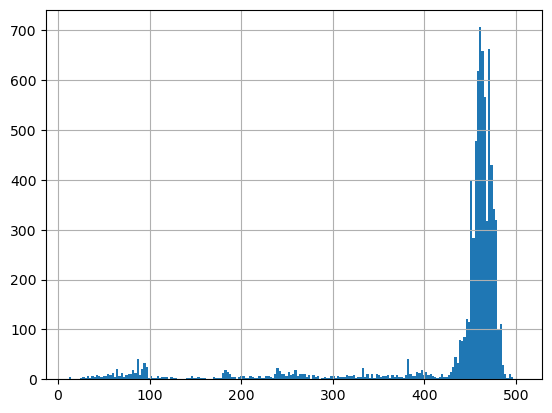

In [ ]:
# how many hits have short aln len?
bac_tophits = pd.read_feather('bacteria_tophits.feather')
arch_tophits = pd.read_feather('archaea_tophits.feather')
tophits = pd.concat([bac_tophits, arch_tophits])

# 200bp good cutoff for nifH aln len (based on hist)

nifH_tophits = tophits[tophits.index.get_level_values(1) =='nifH']
tophits_nifH200 = nifH_tophits[nifH_tophits['Alignment Length'] > 200]

filtered_accessions = tophits_nifH200.index.get_level_values(0).to_list()

tophits_aln_filtered = tophits.loc[filtered_accessions]

nifK_tophits = tophits_aln_filtered[tophits_aln_filtered.index.get_level_values(1) =='nifK'] 
nifK_tophits['Alignment Length'].hist(bins=200)


In [ ]:
# get thermophiles (for Mikhail)

# make sure seqs are in pruned tree (i.e. from nitrogenase clades)
tree = Phylo.read("Nitrogenase_clades.txt", "newick")

# Extract and print node names
nodes = []
for clade in tree.get_terminals():
    nodes.append(clade.name)

# uncluster seqs (using tsv files)
clusters = pd.read_csv('clustered_nifH_hmm_90_cluster.tsv', sep='\t', header=None, index_col = 0)
diazotrophs = clusters[clusters.index.isin(nodes)][1].to_list()

# load GTDB metadata
GTDB_metadata = pd.read_csv('GTDB_metadata.gz', sep = '\t', usecols=['accession', 'gtdb_taxonomy', 'ncbi_taxonomy', 
                                                'ncbi_taxonomy_unfiltered', 'ncbi_country', 'ncbi_isolation_source'])

# get nifD seqs
nifD_seqs = list(SeqIO.parse("filtered_nifD_LAMG.fasta", "fasta"))
nifD_df = pd.DataFrame([(record.id, str(record.seq)) for record in nifD_seqs], columns = ['GenomeID', 'Seq'])

# get nifK seqs
nifK_seqs = list(SeqIO.parse("filtered_nifK_LAMG.fasta", "fasta"))
nifK_df = pd.DataFrame([(record.id, str(record.seq)) for record in nifK_seqs], columns = ['GenomeID', 'Seq'])

# merge dataframes to include accession, metadata, and sequences (for filtering)
diazotrophs = pd.DataFrame(diazotrophs, columns = ['GenomeID'])
diazotrophs = pd.merge(diazotrophs, GTDB_metadata, left_on = 'GenomeID', right_on = 'accession', how = 'left').drop(columns = 'accession')
diazotrophs = pd.merge(diazotrophs, nifD_df, on = 'GenomeID', how = 'left')
diazotrophs = pd.merge(diazotrophs, nifK_df, on = 'GenomeID', how = 'left', suffixes=('_nifD', '_nifK'))

# keep species w/ "therm" or "heat" in taxonomy or isolation source
thermophiles = diazotrophs[diazotrophs.gtdb_taxonomy.str.contains('therm', case = False)]
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_taxonomy.str.contains('therm', case = False)]], ignore_index=True)
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_taxonomy_unfiltered.str.contains('therm', case = False)]], ignore_index=True)
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_country.str.contains('therm', case = False)]], ignore_index=True)
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_country.str.contains('hot', case = False)]], ignore_index=True)
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_isolation_source.str.contains('therm', case = False)]], ignore_index=True)
thermophiles =  pd.concat([thermophiles, diazotrophs[diazotrophs.ncbi_isolation_source.str.contains('hot', case = False)]], ignore_index=True)

# remove duplicates
thermophiles = thermophiles.drop_duplicates(subset = 'GenomeID')

# export to csv
thermophiles.to_csv('thermophiles_LAMG.csv', index = False, sep='\t')

thermophiles

# awk '{print ">" $1 "|" $2; print $NF}' thermophiles_LAMG.csv > thermo_nifK.fasta
# awk '{print ">" $1 "|" $2; print $(NF-1)}' thermophiles_LAMG.csv > thermo_nifD.fasta

,GenomeID,gtdb_taxonomy,ncbi_country,ncbi_isolation_source,ncbi_taxonomy,ncbi_taxonomy_unfiltered,Seq_nifD,Seq_nifK
0,GB_GCA_903822005.1,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,none,lake water,d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__...,d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__...,MSTAIDDTRKIIDEVLEAYPEKVRKARARHLAPNDPAGSCASCKIQ...,MSKLKIKDHSELFLEPEYVDLFERKKEFEDACPDEEVKRVLDWTKT...
1,GB_GCA_937889015.1,d__Bacteria;p__Planctomycetota;c__Planctomycet...,none,metagenome,d__Bacteria;p__Planctomycetota;c__Planctomycet...,d__Bacteria;x__PVC group;p__Planctomycetota;c_...,MAPELIDPERVKQELLQAYPAKVGRKRAGQMVVNRKDTPGESPEIV...,MNLLKGAVRGSQENPTVLLRHTTPNVVERQALTINPAKTCQPIGAM...
2,GB_GCA_937924475.1,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,none,Mariane sediment,d__Bacteria;p__;c__;o__;f__;g__;s__,d__Bacteria;x__environmental samples;s__uncult...,MNTYTINKKNEEEIRHHRVCRSRGGESCAFDGAMIVLQPIADAVHL...,MFAISTTCMAEVIGDDLNAFIKKAKQQGVIPEQLPTPYSNTSSFTG...
3,GB_GCA_002339325.1,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,South Africa:Carltonville,water,d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__...,d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__...,MTRIIEQDTQRIVDEVLEVYPEKTKKERKKHLLANDPECSSSTCGL...,MKVQDHVKLYRREDYEKLFRDKREFECPYPEEEVKKVEEYTKTEEY...
4,GB_GCA_020725335.1,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,Russia: Borehole near Beyelii Yar in Tomsk,groundwater filtered on 0.22 m filters,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,MPRIIEQDTEKLIEEVLEIYPEKTRKERRKHLISNDPECTTSTCQL...,MKIMDHVELYKSEDYKELFENKKQFECPYSEEEVKKIEEYTKTEEY...
...,...,...,...,...,...,...,...,...
1978,GB_GCA_026418275.1,d__Bacteria;p__Bacillota_A;c__Clostridia;o__Ac...,Malaysia: Sungkai; Perak,alkaline hot spring water,d__Bacteria;p__Bacillota;c__Clostridia;o__;f__...,d__Bacteria;x__Terrabacteria group;p__Bacillot...,MPINIQNIEAATRENRLGAITGYHGTIKDLVSKATCCSLKNRERCF...,MTQLIEQLRHVCSLGALQSVLAIHRAVPILHAGPGCGQKLWSATGV...
1981,GB_GCA_026419705.1,d__Bacteria;p__Cyanobacteriota;c__Cyanobacteri...,Malaysia: Sungkai; Perak,alkaline hot spring water,d__Bacteria;p__Cyanobacteriota;c__Cyanophyceae...,d__Bacteria;x__Terrabacteria group;x__Cyanobac...,MIITQGKINELLSEPGCEHNHHTHGDKKNKACKQQAQPGAAQGGCA...,GCVAYFRTHLSRHYKEPFSAVSSSMTEDAAVFGGLNNMIEGLQVSY...
1983,GB_GCA_029266015.1,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,China:Yunnan province,native outdoor hot spring sediment,d__Bacteria;p__Bacteroidota;c__;o__;f__;g__;s__,d__Bacteria;x__FCB group;x__Bacteroidota/Chlor...,MKTKVTMDPERWKAEVLTKYPSKVAKKRAKSIVVNEGDEVKQIQAN...,MLLRHTTDKIIEREALTVNPAKTCQPVGAMYAALGIHGCLPHSHGS...
1984,GB_GCA_030389965.1,d__Bacteria;p__Chloroflexota;c__Chloroflexia;o...,Canada: near Kenora; Ontario; Lake 227; IISD-E...,Single colony of Candidatus Chlorohelix alloph...,d__Bacteria;p__Chloroflexota;c__;o__;f__;g__;s__,d__Bacteria;x__Terrabacteria group;p__Chlorofl...,MAVLKCDATIPERDKHILIKGEGQDGKCSIACNSATTPGDMTERGC...,MSTVVKQERAVSINPLRACAPIGAMLATFGIHGALTINHGSQGCAT...


In [373]:
# information scoring

# open aln file
file = f"../../thermo_nifD.aln"

# store in dataframe        
results = list(SeqIO.parse(file, "fasta"))
acc = [result.id.split('|')[0] for result in results]
seqs = [list(str(result.seq)) for result in results]
des = [[result.description.split('|')[-1]] for result in results]

pssm = pd.DataFrame(seqs, index = acc)

# get counts, frequency, entropy --> score
score = pssm.apply(pd.Series.value_counts, axis = 0) # count
score = score.apply(lambda x: x/1062, axis = 0) # frequency
score.fillna(0, inplace = True) # replace Nan w/ 0
score.loc['information'] = np.log2(22) + score.map(lambda x: x * np.log2(x) if x > 0 else 0).sum() # entropy, 0*log0 = 0
score.iloc[:-1, :] = score.apply(lambda x: x*x.loc['information'], axis = 0).iloc[:-1,:] # individual score (closer to 4.39 = more conserved)

# find sites of interest
score.loc['azo'] = seqs[0]
score.loc['max'] = score.iloc[1:-2, :].idxmax()
sites = score.where(score.loc['max'] == score.loc['azo'], inplace=False)
score.loc['azo-match'] = score.apply(lambda x: x.loc['max'] == x.loc['azo'])

# sites of interest
# sites = score[~score.loc['azo-match']]

In [79]:
score

,0,1,2,3,4,5,6,7,8,9,...,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846
-,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,...,4.330477,4.336893,4.332668,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419,4.444419
A,0.0,0.0,0.0,0.0,0.0,0.004189,0.0,0.0,0.0,0.0,...,0.028815,0.0,0.0,0.0,0.0,0.004189,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.004119,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.004119,0.0,0.0,0.0,0.0,0.0,0.004189,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004123,0.0,0.004189,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004189,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.004189,0.0,0.0,0.0,0.004189,0.0,...,0.008233,0.0,0.0,0.0,0.0,0.0,0.004189,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.037103,0.0,0.0,0.0,0.0,0.0,0.004189,0.0,0.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
K,0.0,0.004189,0.004189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [393]:
file = f"thermo_nifD_features.csv"

features = pd.read_csv(file, header=None, index_col = 0)
features.columns = range(len(features.columns))
features = features.drop(features.columns[-1], axis=1)
features.loc['max'] = features.loc['Consensus']
features.loc['Quality'] = features.apply(lambda x: float(x.loc['Quality']), axis=0)
features.loc['Consensus#'] = features.apply(lambda x: float(x.loc['Consensus#']), axis=0)
features.loc['max'] = features.apply(lambda x: x.loc['Consensus'].strip()[0], axis=0)
features.loc['azo'] = seqs[0]
features.loc['azo_match'] = score.apply(lambda x: x.loc['max'] != x.loc['azo'])
features = features.loc[:, features.loc['azo_match']]

features = features.loc[:, features.loc['Consensus#'] >= 50]
# features = features.loc[:, features.loc['azo'] = 'L']
# features = features.loc[:, features.loc['azo'] == 'I']
# # features = features.loc[:, features.loc['azo'] != 'V']
features#.to_csv('thermo_nifD_features_filt.csv', index = False, sep=',')

,172,174,308,475,485,488,495,502,527,569,...,1083,1126,1205,1220,1244,1271,1282,1286,1306,1314
0,,,,,,,,,,,,,,,,,,,,,
Conservation,1,0,1,1,4,9,9,6,7,7,...,0,3,9,10,4,6,8,9,7,1
Quality,1135.2317,1278.8102,1664.9602,1139.5281,1677.4182,2033.7096,2126.2568,1651.0927,1581.4888,1248.7866,...,1086.1302,1352.8774,1797.6267,1080.2826,878.3229,205.22469,2041.5193,1996.0206,1603.496,1140.915
Consensus#,61.393597,54.613937,65.53672,50.282486,54.613937,58.568737,56.026367,90.20715,71.56309,56.40301,...,50.47081,67.3258,79.472694,56.967983,55.461395,53.483994,59.60452,53.107346,63.276836,52.259888
Consensus,K 61.39%; N 8.66%; D 8.19%; E 2.64%; R 1.69%;...,A 54.61%; K 11.49%; S 8.19%; E 4.90%; R 3.30%...,T 65.54%; S 18.46%; A 3.48%; V 3.48%; R 0.75%...,C 50.28%; A 31.54%; S 12.71%; M 0.47%; V 0.47...,R 54.61%; K 28.06%; S 4.14%; A 3.11%; G 2.35%...,V 58.57%; I 27.50%; L 7.91%; A 2.73%; F 0.47%...,I 56.03%; V 39.64%; A 1.41%; R 0.47%; S 0.47%...,W 90.21%; R 4.24%; S 0.94%; H 0.66%; Y 0.56%;...,T 71.56%; G 8.47%; S 8.10%; A 3.20%; Y 2.35%;...,N 56.40%; T 13.28%; S 12.62%; Q 7.82%; V 1.22...,...,A 50.47%; K 1.51%; S 1.51%; E 0.94%; R 0.85%;...,G 67.33%; A 14.60%; I 4.90%; D 3.77%; S 1.51%...,Y 79.47%; F 14.78%; P 1.98%; V 0.38%; L 0.28%...,Y 56.97%; W 35.40%; H 2.26%; Q 1.41%; D 0.94%...,A 55.46%; H 33.99%; I 1.69%; V 1.51%; T 1.32%...,N 53.48%; I 21.19%; V 13.84%; T 2.17%; R 1.69...,I 59.60%; M 19.96%; V 12.05%; L 6.97%; W 0.19...,V 53.11%; I 22.13%; L 17.23%; M 1.79%; F 1.69...,S 63.28%; N 10.08%; A 9.32%; T 8.38%; C 1.41%...,K 52.26%; R 11.02%; T 7.34%; E 3.95%; Q 3.30%...
Occupancy,938,1018,984,1027,1040,1048,1054,1050,1042,1033,...,610,1040,1045,1054,1050,1045,1052,1053,1034,962
max,K,A,T,C,R,V,I,W,T,N,...,A,G,Y,Y,A,N,I,V,S,K
azo,D,N,S,S,K,I,V,R,G,A,...,-,S,F,W,H,I,M,L,N,Q
azo_match,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [436]:
# thermo to plot MSA

file = f"../Thermo/thermo_nifD.aln"

# store in dataframe        
results = list(SeqIO.parse(file, "fasta"))
acc = [result.id.split('|')[0] for result in results]
seqs = [list(str(result.seq)) for result in results]
des = [[result.description.split('|')[-1]] for result in results]

pssm = pd.DataFrame(seqs, index = acc)
pssm = pssm[pssm.loc[:,502] !='R']
pssm = pssm[pssm.loc[:,527] =='T']
pssm = pssm[(pssm.loc[:,569] !='A')]# | (pssm.loc[:,569] =='T')]
pssm = pssm[pssm.loc[:,691] =='G']
pssm = pssm[(pssm.loc[:,836] =='V') | (pssm.loc[:,836] =='L')| (pssm.loc[:,836] =='I')]
pssm = pssm[(pssm.loc[:,877] !='S') & (pssm.loc[:,877] !='T')]
pssm = pssm[pssm.loc[:,997] !='I']
pssm = pssm[(pssm.loc[:,1314] =='K') | (pssm.loc[:,1314] =='R')]
pssm = pssm[[502, 527, 569, 691, 836, 877, 997, 1314]]
pssm = pssm.drop_duplicates()
pssm

,502,527,569,691,836,877,997,1314
RS_GCF_001687335.1,W,T,Y,G,V,A,V,K
RS_GCF_002898515.1,W,T,S,G,V,C,V,K
RS_GCF_002093115.1,W,T,S,G,I,C,V,K
RS_GCF_011207455.1,W,T,Y,G,V,A,V,R
RS_GCF_027925145.1,W,T,N,G,L,A,V,K
GB_GCA_903896745.1,W,T,N,G,I,A,V,K
RS_GCF_000195755.1,W,T,N,G,V,A,V,R
RS_GCF_000266945.1,W,T,N,G,V,A,V,K
GB_GCA_030065275.1,W,T,N,G,L,A,V,R
RS_GCF_009688965.1,W,T,N,G,I,A,V,R


In [447]:
file = f"../Thermo/thermo_nifK.aln"

# store in dataframe        
results = list(SeqIO.parse(file, "fasta"))
seqs = [list(str(result.seq)) for result in results]
protein = seqs[0]
R = protein.count('R')
H = protein.count('H')
K = protein.count('K')
D = protein.count('D')
E = protein.count('E')

print(R,H,K,D,E)

21 16 39 36 33


In [6]:
file = '../operon-org/structure.pickle'
import pickle

file = pickle.load(open(file, 'rb'))
print(len(file))

remove_list = ['GB_GCA_002898135.1_BDTQ01000234.1', 
             'GB_GCA_021797365.1_JAJZZU010000300.1',
             'GB_GCA_009649835.1_PYCK01000054.1',
             'GB_GCA_014380135.1_JACMKN010000012.1',
             'GB_GCA_017889725.1_JAGGAE010000092.1',
             'GB_GCA_902385025.1_CABMDX010000290.1',
             'GB_GCA_027004315.1_JALTHV010000232.1',
             'GB_GCA_031288575.1_JAITRD010000305.1',
             'GB_GCA_937141995.1_CAKZQX010000080.1',
             'GB_GCA_029778665.1_JAKOPX010000087.1',
             'GB_GCA_031276475.1_JAISMZ010000161.1',
             'RS_GCF_015731765.1_NZ_VRYY01000094.1',
             'GB_GCA_013041765.1_JABDRL010000192.1',
             'GB_GCA_021798485.1_JAJZGK010000148.1',
             'GB_GCA_031290695.1_JAITNB010000026.1',
             'GB_GCA_031278575.1_JAITKD010000016.1',
             'GB_GCA_937886325.1_CALABV010000158.1',
             'GB_GCA_937915285.1_CALDNG010000494.1',
             'GB_GCA_021802595.1_JAJZRT010000330.1']

for item in remove_list:
    to_remove = '../operon-org/input-fastas/' + item + '_operon.fasta'
    try:
        file.pop(to_remove)
    except:
        pass

pickle.dump(file, open('../operon-org/structure-update.pickle', 'wb'))
print(len(file))

5592
5592
